In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/vlian/anaconda3/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from tqdm import trange

In [3]:
wireplane = "V"

In [4]:
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(cln_filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    return raw_waveforms

# Load data, select ADC

In [5]:
#Load Training Data
path = "/home/vlian/DUNE-LArTPC-1dCNN/lartpc-dune-1dcnn-main/dunesnb/1dcnn/train/train/nu_cc/"
path2 = "/home/vlian/DUNE-LArTPC-1dCNN/lartpc-dune-1dcnn-main/dunesnb/1dcnn/train/train/nu_es/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in filenames])

noise_path = "/home/vlian/DUNE-LArTPC-1dCNN/lartpc-dune-1dcnn-main/dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and sig_name in f)]
#print(noise_filenames)
noise_clean_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and cln_name in f)]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])


# Train/Noise Data Preprocessing

In [6]:
from sklearn.utils import shuffle
print(combined_data.shape[0])
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (incl > ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print(combined_data.shape[0])

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print(combined_data.shape[0])
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print(combined_data.shape[0])
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)

#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print(test_signal_waveforms.shape[0])
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])


# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(
    noise_waveforms, y_noise_full, test_size=0.5, shuffle=True
)

#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)

#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))

x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)

# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)

#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

231744
130731
65365
62292
65366


In [7]:
x_train.shape

(86880, 200)

In [8]:
x_valid.shape

(21720, 200)

In [9]:
mean = x_train.mean()
std = x_train.std()

In [10]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
time_periods = 200

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [ ]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #third convolutional block
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model


model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 99, 16)            64        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 49, 16)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 23, 32)            2592      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3, 64)             18496     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)               

In [ ]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)
print(x_train_scaled.shape[0])
print(x_valid_scaled.shape[0])
print(x_test_scaled.shape[0])

86880
21720
108600


In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [ ]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100
43/43 [==============================] - 2s 44ms/step - loss: 0.6422 - accuracy: 0.4858 - val_loss: 0.5804 - val_accuracy: 0.4991
Epoch 2/100
43/43 [==============================] - 2s 36ms/step - loss: 0.5723 - accuracy: 0.5156 - val_loss: 0.5269 - val_accuracy: 0.6990
Epoch 3/100
43/43 [==============================] - 2s 38ms/step - loss: 0.5174 - accuracy: 0.7365 - val_loss: 0.4698 - val_accuracy: 0.8716
Epoch 4/100
43/43 [==============================] - 2s 40ms/step - loss: 0.4627 - accuracy: 0.8605 - val_loss: 0.4160 - val_accuracy: 0.8575
Epoch 5/100
43/43 [==============================] - 2s 38ms/step - loss: 0.4123 - accuracy: 0.8567 - val_loss: 0.3765 - val_accuracy: 0.8595
Epoch 6/100
43/43 [==============================] - 2s 35ms/step - loss: 0.3761 - accuracy: 0.8586 - val_loss: 0.3491 - val_accuracy: 0.8639
Epoch 7/100
43/43 [==============================] - 2s 35ms/step - loss: 0.3503 - accuracy: 0.8652 - val_loss: 0.3293 - val_accuracy: 0.8669
Epoch 

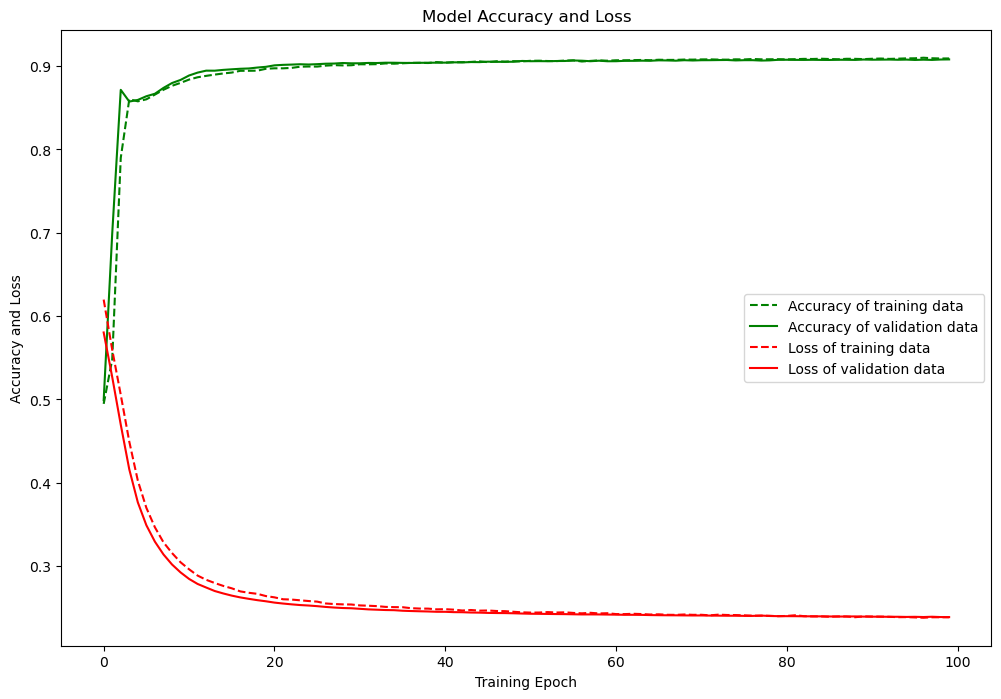

In [60]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [61]:
import gc
gc.collect()

8018

In [62]:
model.save("learn_models/" + wireplane + "plane_nu.h5")

In [63]:
history.history['loss']

[0.6198597550392151,
 0.5597519874572754,
 0.5055708289146423,
 0.44936415553092957,
 0.4025932550430298,
 0.3699061870574951,
 0.3465794622898102,
 0.32862573862075806,
 0.3157470226287842,
 0.3046528100967407,
 0.29621562361717224,
 0.2886601686477661,
 0.28360864520072937,
 0.2797560691833496,
 0.27627307176589966,
 0.2733791172504425,
 0.26967281103134155,
 0.26801085472106934,
 0.2667464315891266,
 0.2640479803085327,
 0.2625299096107483,
 0.2602490186691284,
 0.2598874568939209,
 0.2589800953865051,
 0.2581176459789276,
 0.25739586353302,
 0.2551884651184082,
 0.25450611114501953,
 0.254111647605896,
 0.2539542615413666,
 0.2528592348098755,
 0.25247782468795776,
 0.25199994444847107,
 0.2510991096496582,
 0.2507946789264679,
 0.25069659948349,
 0.24951370060443878,
 0.24908195436000824,
 0.2489980310201645,
 0.2481396347284317,
 0.2483256757259369,
 0.24776533246040344,
 0.24675115942955017,
 0.24735118448734283,
 0.24657708406448364,
 0.2467583417892456,
 0.24615934491157532,
 

In [64]:
history.history['val_loss']

[0.5804399847984314,
 0.5269364714622498,
 0.469766765832901,
 0.41604018211364746,
 0.37650442123413086,
 0.34906089305877686,
 0.3293471336364746,
 0.31406456232070923,
 0.3020017743110657,
 0.29249751567840576,
 0.28465160727500916,
 0.27860748767852783,
 0.2743426561355591,
 0.2701456844806671,
 0.2672143280506134,
 0.2646114230155945,
 0.2624588906764984,
 0.26074159145355225,
 0.25915154814720154,
 0.2578061521053314,
 0.2562365233898163,
 0.25511234998703003,
 0.2541424632072449,
 0.2532975673675537,
 0.25272369384765625,
 0.25196629762649536,
 0.25102829933166504,
 0.25030651688575745,
 0.24972783029079437,
 0.24945582449436188,
 0.24877913296222687,
 0.24809530377388,
 0.24770523607730865,
 0.2473221868276596,
 0.24714605510234833,
 0.24647369980812073,
 0.24611926078796387,
 0.24582910537719727,
 0.24557550251483917,
 0.24521832168102264,
 0.24518953263759613,
 0.24478161334991455,
 0.24469047784805298,
 0.24432942271232605,
 0.24419264495372772,
 0.2438654601573944,
 0.24371

In [65]:
history.history['accuracy']

[0.4947168529033661,
 0.5479512214660645,
 0.7899286150932312,
 0.8603015542030334,
 0.8577923774719238,
 0.8602094650268555,
 0.865884006023407,
 0.8716620802879333,
 0.8764272332191467,
 0.8799378275871277,
 0.8838973045349121,
 0.886671245098114,
 0.888363242149353,
 0.8898595571517944,
 0.8912407755851746,
 0.8923227190971375,
 0.8944175839424133,
 0.8944520950317383,
 0.8945902585983276,
 0.8968692421913147,
 0.8974217176437378,
 0.8974102139472961,
 0.8979281783103943,
 0.8993324041366577,
 0.8995741009712219,
 0.8994820713996887,
 0.9006445407867432,
 0.9012200832366943,
 0.9008978009223938,
 0.9010819792747498,
 0.9022560119628906,
 0.9021984338760376,
 0.9023826122283936,
 0.9033033847808838,
 0.9029580950737,
 0.9034760594367981,
 0.9039249420166016,
 0.9040285348892212,
 0.9037638306617737,
 0.9048572778701782,
 0.9042012095451355,
 0.9047536849975586,
 0.9047881960868835,
 0.9050644636154175,
 0.9058011174201965,
 0.9047766923904419,
 0.9059162139892578,
 0.9053637385368347

In [66]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

27/27 [==============================] - 0s 16ms/step - loss: 0.2314 - accuracy: 0.9114


[0.23139619827270508, 0.9114180207252502]

In [67]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [68]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=4096)

CPU times: user 2.05 s, sys: 83.2 ms, total: 2.14 s
Wall time: 438 ms


<AxesSubplot:>

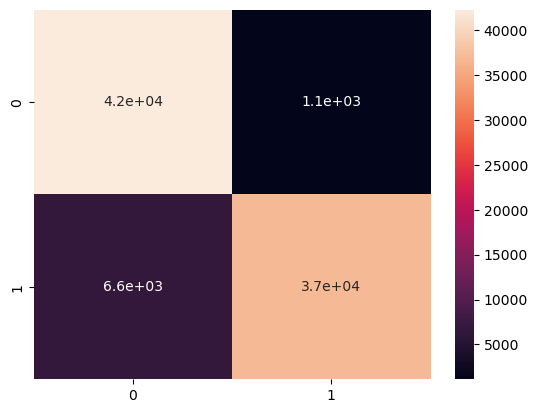

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<AxesSubplot:>

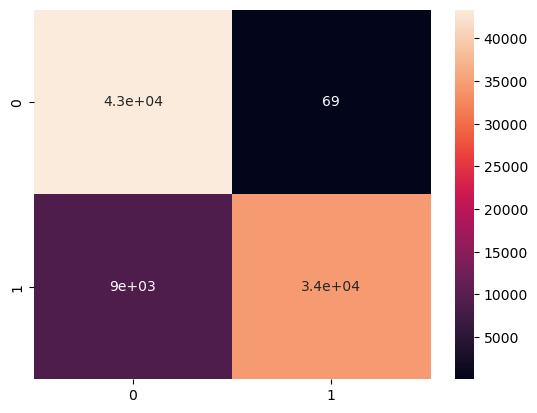

In [70]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

In [71]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)

In [72]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [73]:
np.save("learn_results/false_positive_" + wireplane + "_train", fpr_keras)
np.save("learn_results/true_positive_" + wireplane + "_train", tpr_keras)
np.save("learn_results/thresholds_" + wireplane + "_train", thresholds_keras)

In [74]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

# Valid

In [75]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

CPU times: user 594 ms, sys: 1.53 ms, total: 595 ms
Wall time: 119 ms


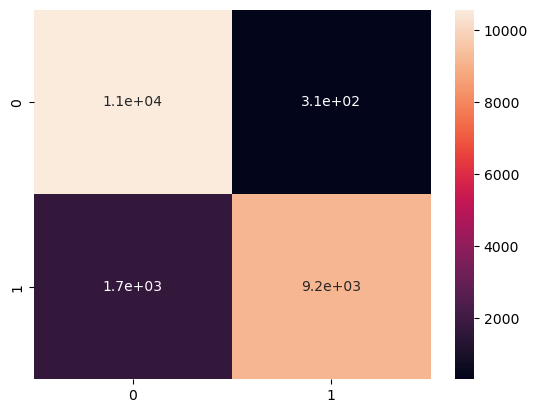

In [76]:
from sklearn.metrics import confusion_matrix
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

<AxesSubplot:>

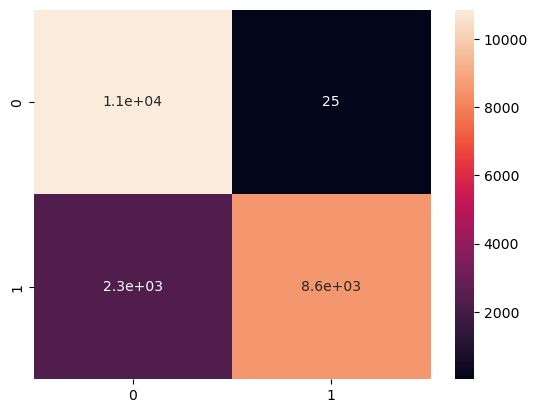

In [77]:
from sklearn.metrics import confusion_matrix
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

In [78]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)

In [79]:
np.save("learn_results/false_positive_" + wireplane + "_valid", fpr_keras)
np.save("learn_results/true_positive_" + wireplane + "_valid", tpr_keras)
np.save("learn_results/thresholds_" + wireplane + "_valid", thresholds_keras)

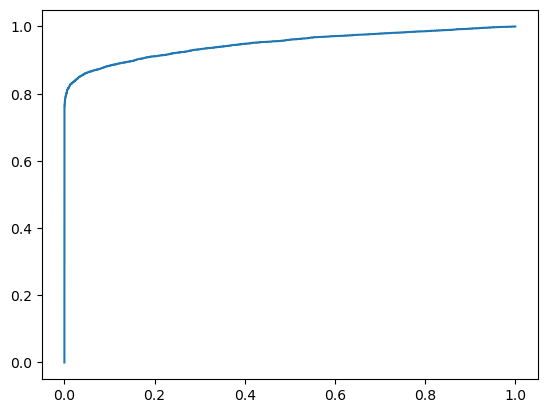

In [80]:
plt.plot(fpr_keras, tpr_keras)

# test

In [81]:
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


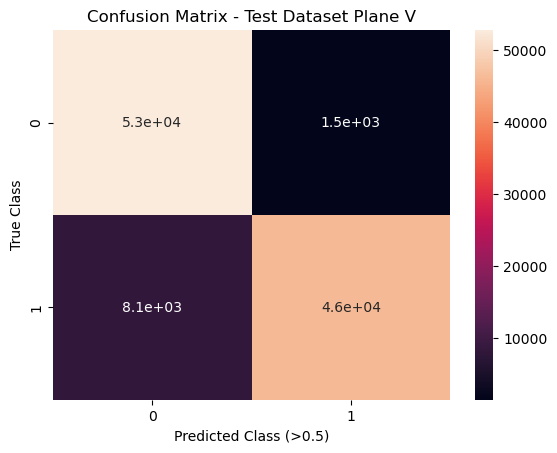

In [82]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

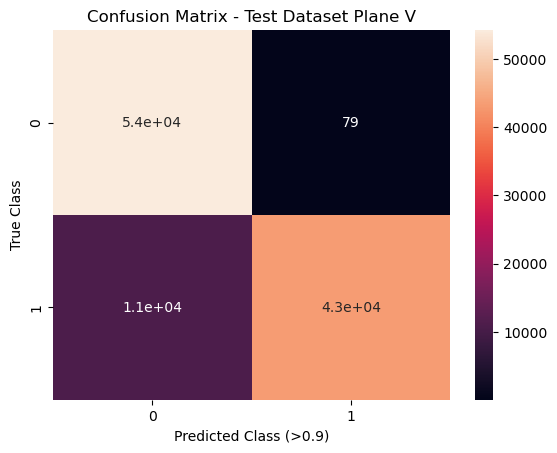

In [83]:
all2 = confusion_matrix(all_y_test, all_infer>0.9)
sns.heatmap(all2, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.9)")
plt.ylabel("True Class")
plt.show()

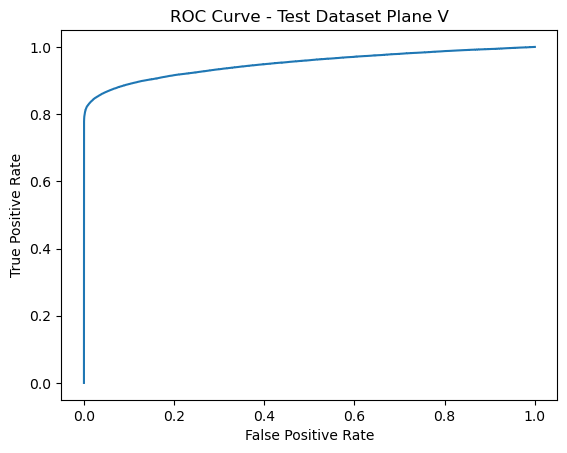

In [84]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras)
plt.title("ROC Curve - Test Dataset Plane " + wireplane)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [85]:
np.save("learn_results/false_positive_V_test", fpr_keras)
np.save("learn_results/true_positive_V_test", tpr_keras)
np.save("learn_results/thresholds_V_test", thresholds_keras)

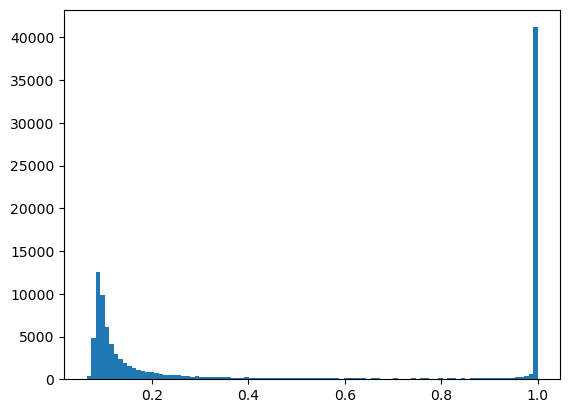

In [86]:
plt.hist(all_infer, bins = 100);

In [87]:
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)